<a href="https://colab.research.google.com/github/GPN87/Rosella-image-detection/blob/main/classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import tensorflow as tf
import os
from matplotlib import pyplot as plt
import cv2
import imghdr

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
data_dir = '/content/drive/MyDrive/data/'


In [5]:
os.listdir(data_dir)

['crimson', 'eastern']

In [6]:
image_exts = ['jpeg','jpg', 'bmp', 'png']

In [7]:
for image_class in os.listdir(data_dir): 
    for image in os.listdir(os.path.join(data_dir, image_class)):
        image_path = os.path.join(data_dir, image_class, image)
        try: 
            img = cv2.imread(image_path)
            tip = imghdr.what(image_path)
            if tip not in image_exts: 
                print('Image not in ext list {}'.format(image_path))
                os.remove(image_path)
        except Exception as e: 
            print('Issue with image {}'.format(image_path))
            # os.remove(image_path)

Start of loading data

In [8]:
import numpy as np

In [19]:
# keras utils is a data pipeline 'helper'. It builds the image dataset on the fly.
# batches them, classifies them. makes sure they are consistent size.
data = tf.keras.utils.image_dataset_from_directory(data_dir)

Found 448 files belonging to 2 classes.


In [10]:
#converts into a numpy iterator
#so we can actually access it
data_iterator = data.as_numpy_iterator()

In [11]:
batch = data_iterator.next()

#each image in the batch consists of an array representing the image, and a '1' or '0' representing the classification

batch[0].shape
#It's really important to get the shape of your images, so you refer to them correctly in the model below.
#in this case, 32 images, with 256 height, 256 width, 3 channels (i.e. color)


(32, 256, 256, 3)

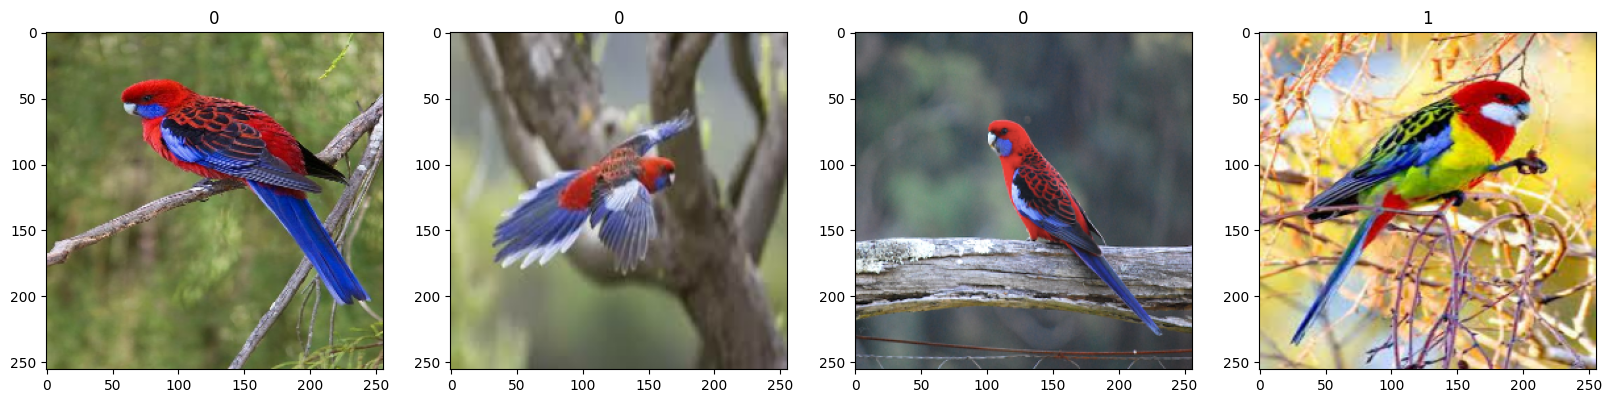

In [12]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, img in enumerate(batch[0][:4]):
    ax[idx].imshow(img.astype(int))
    ax[idx].title.set_text(batch[1][idx])
#0s are crimsons and 1s are easterns

In [13]:
data = data.map(lambda x,y: (x/255, y))

In [14]:
data.as_numpy_iterator().next()

(array([[[[0.17901348, 0.2080576 , 0.19053309],
          [0.18291973, 0.20644914, 0.19076286],
          [0.18370098, 0.20723039, 0.19154412],
          ...,
          [0.1873315 , 0.21478248, 0.18340993],
          [0.17970282, 0.2189185 , 0.17896752],
          [0.18590686, 0.22512256, 0.18982843]],
 
         [[0.18517157, 0.20870098, 0.19301471],
          [0.18224572, 0.20577513, 0.19008885],
          [0.18186274, 0.20539215, 0.18970588],
          ...,
          [0.19080882, 0.2182598 , 0.18688725],
          [0.17660846, 0.21582414, 0.17587316],
          [0.17809436, 0.21731006, 0.18201593]],
 
         [[0.1801011 , 0.2070772 , 0.19024204],
          [0.18446691, 0.20739889, 0.19171262],
          [0.1850337 , 0.20856312, 0.19287685],
          ...,
          [0.19067095, 0.21812193, 0.18674938],
          [0.18578431, 0.2214614 , 0.18501838],
          [0.18734682, 0.22215073, 0.18832721]],
 
         ...,
 
         [[0.31194854, 0.29463848, 0.37976408],
          [0.30940

Pre-processing the data

In [20]:
#you've got to scale the image values to be between '0' and '1' instead of 0 to 255.
#you use a lambda function to do that
#The data pipeline has a 'map' function that allows us to lambda. So it makes the calculation automatically.
#'x' represents the image array. so we're dividing it by 255 to standardise the number. Nothing happens to 'y'
data = data.map(lambda x,y: (x/255, y))

In [21]:
scaled_iterator = data.as_numpy_iterator()

In [22]:
batch = scaled_iterator.next()

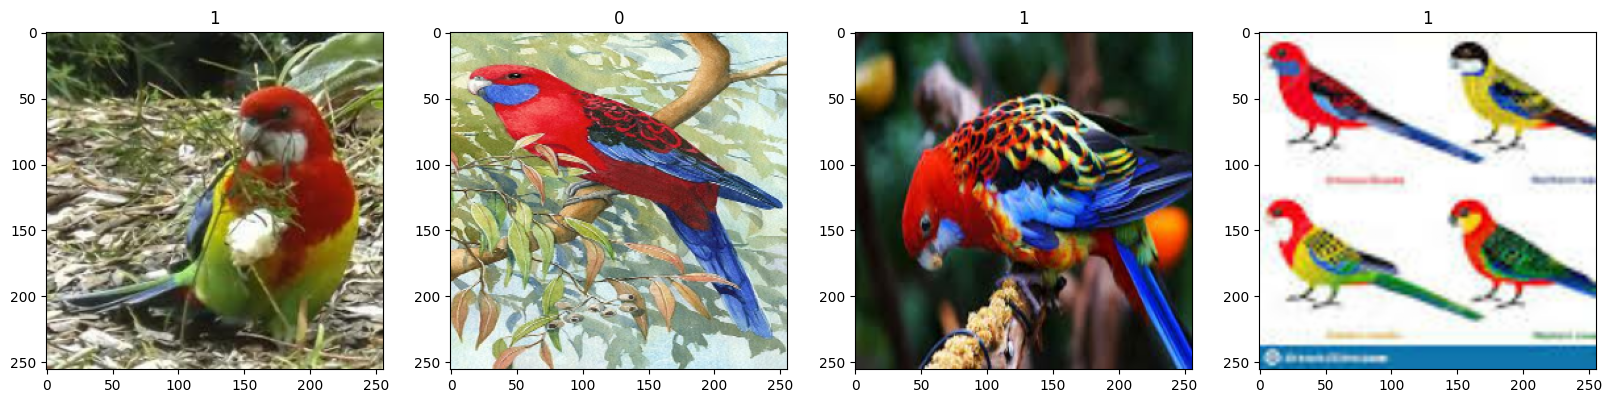

In [23]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, img in enumerate(batch[0][:4]):
    ax[idx].imshow(img)
    ax[idx].title.set_text(batch[1][idx])

Split Data.

In [24]:
len(data)

14

In [25]:
train_size = int(len(data)*.7)
val_size = int(len(data)*.2)+1
test_size = int(len(data)*.1)+1

In [26]:
train_size

9

In [27]:
#Training data: what is used to train the model
#validation data: what we use to evaluate model while we're 
#Test data: used post training. 
# uses the 'Take' and 'skip' methods

In [28]:
train = data.take(train_size)
val = data.skip(train_size).take(val_size)
test = data.skip(train_size+val_size).take(test_size)

Build Deep Learning Model

In [54]:
#Uses the Keras sequential API
from tensorflow.keras.models import Sequential, save_model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout

#There are two model building APIs in tensorflow. The first is "sequential". Good when you've got one data input and one data output. Quick, easy.
#another is functional API. when you've got multiple connections.
#Conv2D, MaxPooling, Dense, Flatten, Dropout are all layers. See your background on CNN.

In [30]:
model = Sequential()

In [31]:
model.add(Conv2D(16, (3,3), 1, activation='relu', input_shape=(256,256,3)))
model.add(MaxPooling2D())
model.add(Conv2D(32, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())
model.add(Conv2D(16, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

#16 is the number of filters. Each filter matrix is 3x3 pixels. Each filter moves 1 pixel at a time. Input shape corresponds to the image array mentioned above.
#generally start with a relu activation function, if you dont want negative values. and output a sigmoid if '0' and '1'
#Dense layer = fully connected layer in Keras parlance.


In [32]:
model.compile('adam', loss=tf.losses.BinaryCrossentropy(), metrics=['accuracy'])
#the metric we want to track is "accuracy"

In [33]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 254, 254, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 127, 127, 16)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 32)      4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 62, 62, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 60, 60, 16)        4624      
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 30, 30, 16)       0

Train the data

In [34]:
#create a log directory.
logdir = '/content/drive/MyDrive/logs/'

In [35]:
#this creates a callback. Good for creating callbacks.
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

In [36]:
hist = model.fit(train, epochs=20, validation_data=val, callbacks=[tensorboard_callback])


Epoch 1/20
9/9 [==============================] - 47s 5s/step - loss: 1.2146 - accuracy: 0.5417 - val_loss: 0.6894 - val_accuracy: 0.5625
Epoch 2/20
9/9 [==============================] - 36s 4s/step - loss: 0.6675 - accuracy: 0.6285 - val_loss: 0.6914 - val_accuracy: 0.5938
Epoch 3/20
9/9 [==============================] - 34s 3s/step - loss: 0.6689 - accuracy: 0.5972 - val_loss: 0.6500 - val_accuracy: 0.6771
Epoch 4/20
9/9 [==============================] - 33s 3s/step - loss: 0.6094 - accuracy: 0.6771 - val_loss: 0.5435 - val_accuracy: 0.7604
Epoch 5/20
9/9 [==============================] - 35s 4s/step - loss: 0.4875 - accuracy: 0.8194 - val_loss: 0.3709 - val_accuracy: 0.8646
Epoch 6/20
9/9 [==============================] - 30s 3s/step - loss: 0.3300 - accuracy: 0.8576 - val_loss: 0.2982 - val_accuracy: 0.8750
Epoch 7/20
9/9 [==============================] - 34s 3s/step - loss: 0.3927 - accuracy: 0.8646 - val_loss: 0.2870 - val_accuracy: 0.8854
Epoch 8/20
9/9 [==================

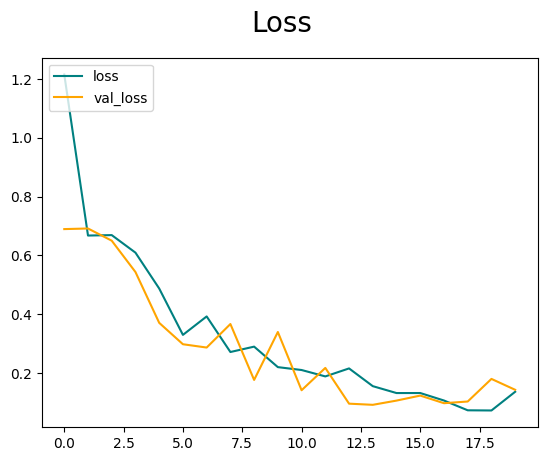

In [37]:
fig = plt.figure()
plt.plot(hist.history['loss'], color='teal', label='loss')
plt.plot(hist.history['val_loss'], color='orange', label='val_loss')
fig.suptitle('Loss', fontsize=20)
plt.legend(loc="upper left")
plt.show()

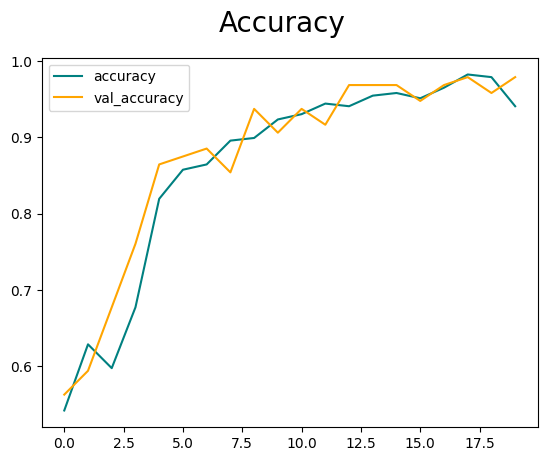

In [38]:
fig = plt.figure()
plt.plot(hist.history['accuracy'], color='teal', label='accuracy')
plt.plot(hist.history['val_accuracy'], color='orange', label='val_accuracy')
fig.suptitle('Accuracy', fontsize=20)
plt.legend(loc="upper left")
plt.show()

In [39]:
from tensorflow.keras.metrics import Precision, Recall, BinaryAccuracy

In [40]:
pre = Precision()
re = Recall()
acc = BinaryAccuracy()

In [41]:
for batch in test.as_numpy_iterator(): 
    X, y = batch
    yhat = model.predict(X)
    pre.update_state(y, yhat)
    re.update_state(y, yhat)
    acc.update_state(y, yhat)

1/1 [==============================] - 1s 603ms/step


In [42]:
print(f'Precision: {pre.result()}, Recall: {re.result()}, Accuracy: {acc.result()}')

Precision: 0.9473684430122375, Recall: 0.8999999761581421, Accuracy: 0.953125


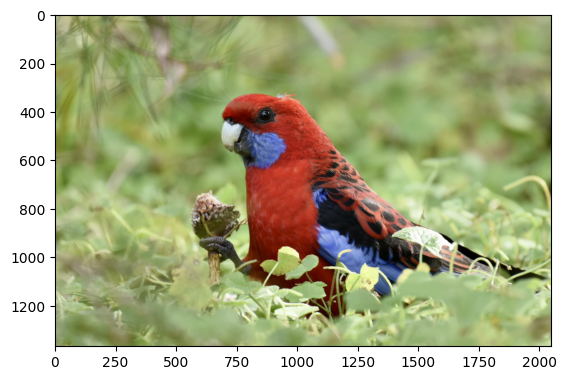

In [48]:
filename = '/content/drive/MyDrive/crimsontest.jpeg'
if os.path.exists(filename):
    img1 = cv2.imread(filename)
    plt.imshow(cv2.cvtColor(img1, cv2.COLOR_BGR2RGB))
    plt.show()
else:
    print("Error: Image file does not exist.")

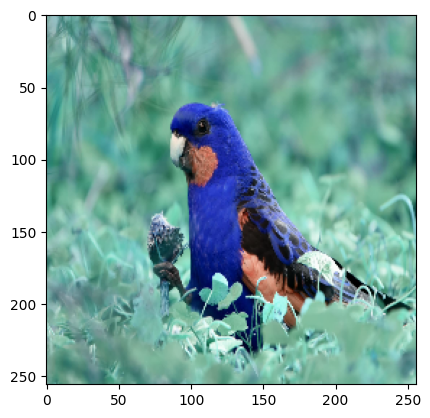

In [49]:
resize = tf.image.resize(img1, (256,256))
plt.imshow(resize.numpy().astype(int))
plt.show()
#It's only a weird colour because we've opened it up in cv2.

In [51]:
yhat = model.predict(np.expand_dims(resize/255, 0))
#The Neural network expects a batch of images, not a single image.
#So we need to encapsulate it in another dimension.

1/1 [==============================] - 0s 44ms/step


In [52]:
yhat

array([[0.39300972]], dtype=float32)

In [53]:
if yhat > 0.5: 
    print(f'Beep boop.. this is an Eastern Rosella')
else:
    print(f'Beep boop.. this is a Crimson Rosella')

Beep boop.. this is a Crimson Rosella


In [58]:
model.save('/content/drive/MyDrive/saved_model.h5')